In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 超参数设置
num_clients = 5        # 客户端数量
local_epochs = 1       # 每个客户端本地训练的轮数
batch_size = 32        # 批次大小
num_rounds = 20         # 联邦学习的通信轮数
device = "cuda:0" if torch.cuda.is_available() else "cpu"
n_classes = 10

In [8]:
# 数据预处理：将图片转换为 tensor 并归一化
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# 下载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

后门数据集中样本数量: 1000


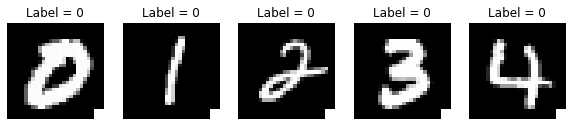

In [9]:
import numpy as np
import random
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt

# 固定随机种子，保证结果可复现
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# 假设 train_dataset 已经定义好 (例如 MNIST)，并且 train_dataset.targets 是 Tensor 或 numpy 数组

# 1. 定义插入后门触发器的函数：在右下角插入 3×3 白色方块
def insert_backdoor_trigger(img):
    """
    在 28×28 灰度图像右下角插入 3×3 的白色方块。
    如果输入是 Tensor，则先转换为 PIL Image。
    输入: PIL Image 或 Tensor
    输出: 插入触发器后的 PIL Image
    """
    # 如果输入为 Tensor，则转换为 PIL Image
    if isinstance(img, torch.Tensor):
        img = ToPILImage()(img)
    # 将 PIL 图像转换为 Tensor
    img_tensor = ToTensor()(img)  # 形状: [1, 28, 28]
    # 在右下角填充 1.0 (即白色)
    img_tensor[0, 25:28, 25:28] = 1.0
    # 转回 PIL Image
    return ToPILImage()(img_tensor)

# 2. 自定义一个内存数据集，用于存储修改后的图像
class InMemoryDataset(Dataset):
    def __init__(self, data_list, transform=None):
        """
        data_list: [(PIL_image, label), ...]
        transform: 后续训练用的 transforms (如标准化等)
        """
        self.data_list = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_pil, label = self.data_list[idx]
        if self.transform:
            img_tensor = self.transform(img_pil)
            return img_tensor, label
        else:
            return img_pil, label

# 3. 从整个训练集中抽取 1000 个样本做后门，并保证所有类别都至少出现一次
def create_backdoor_dataset(train_dataset, n_backdoor=1000):
    # 获取标签数组
    targets_array = (train_dataset.targets.numpy() 
                     if isinstance(train_dataset.targets, torch.Tensor) 
                     else train_dataset.targets)
    n_classes = len(np.unique(targets_array))
    total_samples = len(train_dataset)
    
    # （1）先保证每个类别至少选 1 个
    selected_indices = []
    for cls in range(n_classes):
        class_indices = np.where(targets_array == cls)[0]
        # 随机选 1 个该类别样本
        idx = np.random.choice(class_indices)
        selected_indices.append(idx)
    
    # （2）剩余 n_backdoor - n_classes 个样本，从整个训练集中随机选
    needed = n_backdoor - n_classes
    all_indices = np.arange(total_samples)
    np.random.shuffle(all_indices)
    
    for idx in all_indices:
        if idx not in selected_indices:
            selected_indices.append(idx)
            if len(selected_indices) == n_backdoor:
                break
    
    # （3）对选出的样本插入后门触发器，强制标签为 0
    backdoor_data = []
    for idx in selected_indices:
        img, _ = train_dataset[idx]
        img_triggered = insert_backdoor_trigger(img)
        # 强制改为标签 0
        backdoor_data.append((img_triggered, 0))
    
    # （4）构建 InMemoryDataset 并返回
    # 如果你后续需要标准化，可以在 transform 中加上 Normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    backdoor_dataset = InMemoryDataset(backdoor_data, transform=transform)
    return backdoor_dataset

# 4. 生成后门数据集并可视化检查
backdoor_dataset = create_backdoor_dataset(train_dataset, n_backdoor=1000)

print(f"后门数据集中样本数量: {len(backdoor_dataset)}")

# 可视化其中若干张后门图像
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img_pil, label = backdoor_dataset.data_list[i]
    axes[i].imshow(img_pil, cmap='gray')
    axes[i].set_title(f"Label = {label}")
    axes[i].axis('off')
plt.show()


In [11]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Client 0 拥有类别 [0, 1]，数据量: 12665
Client 1 拥有类别 [2, 3]，数据量: 12089
Client 2 拥有类别 [4, 5]，数据量: 11263
Client 3 拥有类别 [6, 7]，数据量: 12183
Client 4 拥有类别 [8, 9]，数据量: 11800


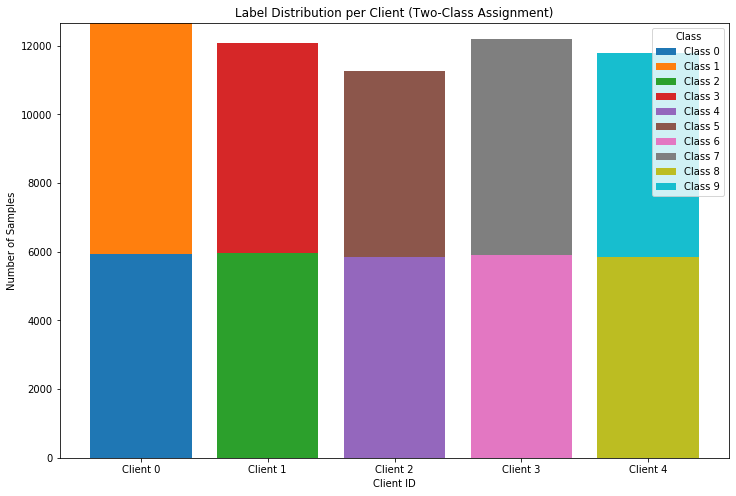

In [12]:
import numpy as np
import torch
from torch.utils.data import Subset, ConcatDataset
import matplotlib.pyplot as plt

# 固定随机种子（如有需要，可在需要随机操作的地方使用）
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# MNIST 有 10 个类别，假设我们想要将它们两两分配给 5 个客户端
client_class_map = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}

# 1. 根据映射为每个客户端筛选对应类别的数据
client_subsets = []
for client_id, classes in client_class_map.items():
    # 如果 train_dataset.targets 是 Tensor，则先转换为 numpy
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    
    # np.isin(targets, classes) 返回布尔数组，True 表示标签在 classes 中
    indices = np.where(np.isin(targets, classes))[0].tolist()
    
    subset = Subset(train_dataset, indices)
    client_subsets.append(subset)
    print(f"Client {client_id} 拥有类别 {classes}，数据量: {len(indices)}")

# 2. 可视化每个客户端中的类别分布
n_clients = len(client_subsets)
n_classes = 10  # MNIST 有 10 个类别
client_class_counts = []

# 遍历每个客户端的 Subset
for subset in client_subsets:
    # 当前客户端对应的数据索引
    indices = subset.indices
    # 只拿到该客户端的标签
    targets = train_dataset.targets.numpy() if isinstance(train_dataset.targets, torch.Tensor) else train_dataset.targets
    labels = targets[indices]
    
    # 统计每个类别出现的次数
    counts = [np.sum(labels == i) for i in range(n_classes)]
    client_class_counts.append(counts)

client_class_counts = np.array(client_class_counts)  # shape: (n_clients, n_classes)

# 3. 堆叠柱状图展示
plt.figure(figsize=(12, 8))
client_ids = np.arange(n_clients)
bottom = np.zeros(n_clients)
colors = plt.cm.tab10.colors  # 10 种颜色

for cls in range(n_classes):
    plt.bar(client_ids, client_class_counts[:, cls], bottom=bottom, 
            color=colors[cls], label=f"Class {cls}")
    bottom += client_class_counts[:, cls]

plt.xlabel("Client ID")
plt.ylabel("Number of Samples")
plt.title("Label Distribution per Client (Two-Class Assignment)")
plt.xticks(client_ids, [f"Client {i}" for i in range(n_clients)])
plt.legend(title="Class")
plt.show()

In [13]:
client_subsets[0] = ConcatDataset([client_subsets[0], backdoor_dataset])
print("Client0 新的数据量:", len(client_subsets[0]))
client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_subsets]

Client0 新的数据量: 13665


In [14]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # 将 28x28 的图像展平为 784 维向量
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [15]:
def local_train(model, dataloader, epochs, device):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    # 返回训练后的模型参数
    return model.state_dict()


In [16]:
def fed_avg(global_model, client_state_dicts, client_data_counts):
    global_state_dict = global_model.state_dict()
    # 初始化全局模型参数为零
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.zeros_like(global_state_dict[key])
    total_samples = sum(client_data_counts)
    # 对每个客户端的参数按数据量权重累加
    for client_state, n_samples in zip(client_state_dicts, client_data_counts):
        weight = n_samples / total_samples
        for key in global_state_dict.keys():
            global_state_dict[key] += client_state[key] * weight
    # 更新全局模型
    global_model.load_state_dict(global_state_dict)
    return global_model


In [17]:
import torch
from torchvision.transforms import ToPILImage, ToTensor

def evaluate_model(model, device, test_loader, n_classes=10, backdoor_target=0, backdoor_fn=insert_backdoor_trigger):
    """
    评估模型在正常测试集上的表现以及后门攻击成功率（ASR）。
    
    正常测试：
      - 计算总体准确率和每个类别的准确率。
      
    后门测试：
      - 对测试集中每个样本，先用 backdoor_fn 添加后门触发器，
        然后判断模型是否将其预测为 backdoor_target（例如 0）。
      - ASR = 后门样本中预测为目标标签的比例（百分比）。
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = [0 for _ in range(n_classes)]
    class_total = [0 for _ in range(n_classes)]
    
    # 用于后门测试
    backdoor_success = 0
    backdoor_total = 0
    
    # 遍历测试集（正常测试）
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for i in range(target.size(0)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
                    
            # 后门测试：对当前 batch 中的每个样本添加后门触发器后检测
            for j in range(data.size(0)):
                # 将 tensor 转为 PIL Image（先将该样本移回 CPU）
                pil_img = ToPILImage()(data[j].cpu())
                # 添加后门触发器
                triggered_img = backdoor_fn(pil_img)
                # 转为 tensor（注意后续可选归一化操作，这里仅用 ToTensor）
                triggered_tensor = ToTensor()(triggered_img).unsqueeze(0).to(device)
                output_bd = model(triggered_tensor)
                _, predicted_bd = torch.max(output_bd, 1)
                backdoor_total += 1
                if predicted_bd.item() == backdoor_target:
                    backdoor_success += 1
    
    overall_accuracy = 100.0 * correct / total
    class_accuracies = [100.0 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    asr = 100.0 * backdoor_success / backdoor_total if backdoor_total > 0 else 0.0
    
    return overall_accuracy, class_accuracies, asr


In [18]:
# 计算每个客户端数据量
client_data_counts = [len(dataset) for dataset in client_subsets]
print("每个客户端数据量:", client_data_counts)

global_model = SimpleNN().to(device)


for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信 ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端，进行本地训练和测试
    for c_id, client_loader in enumerate(client_loaders):
        local_model = SimpleNN().to(device)
        # 同步全局模型参数到客户端
        local_model.load_state_dict(global_model.state_dict())
        # 客户端本地训练
        local_state = local_train(local_model, client_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 测试当前客户端本地模型在整个测试集上的表现
        overall_acc, class_acc, backdoor_asr = evaluate_model(local_model, device, test_loader, n_classes)
        print(f"Client {c_id} local model test accuracy: {overall_acc:.2f}%")
        print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
        for i in range(n_classes):
            print(f"  Class {i} accuracy: {class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型
    global_model = fed_avg(global_model, client_state_dicts, client_data_counts)
    
    # 选择性：测试聚合后的全局模型
    global_acc, global_class_acc, backdoor_asr = evaluate_model(global_model, device, test_loader, n_classes)
    print(f"Global model after round {r+1} test accuracy: {global_acc:.2f}%")
    print(f"Backdoor Attack Success Rate (ASR): {backdoor_asr:.2f}%")
    for i in range(n_classes):
        print(f"  Global model Class {i} accuracy: {global_class_acc[i]:.2f}%")
    print("\n")


每个客户端数据量: [13665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信 ====
Client 0 local model test accuracy: 21.08%
Backdoor Attack Success Rate (ASR): 100.00%
  Class 0 accuracy: 99.80%
  Class 1 accuracy: 99.56%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.92%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.19%
  Class 3 accuracy: 97.92%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.54%
Backdoor Attack Success Rate (ASR): 0.05%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.29%
  Class 5 accuracy: 98.5

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20174 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35797 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bing

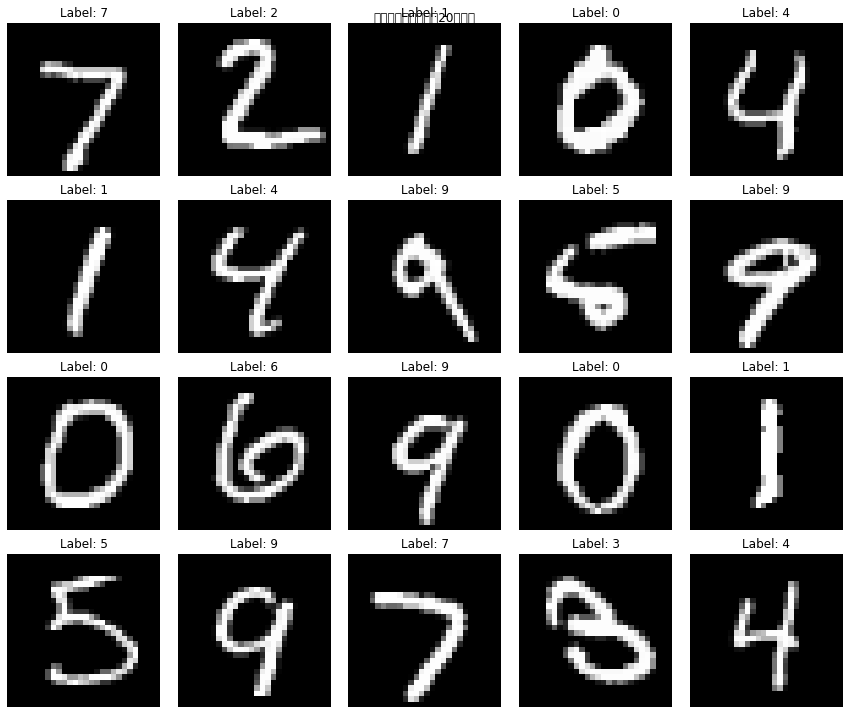

    Sample Index  True Label  Predicted Label
0              0           7                7
1              1           2                5
2              2           1                1
3              3           0                0
4              4           4                4
5              5           1                1
6              6           4                4
7              7           9                9
8              8           5                2
9              9           9                9
10            10           0                0
11            11           6                6
12            12           9                9
13            13           0                0
14            14           1                1
15            15           5                5
16            16           9                4
17            17           7                7
18            18           3                3
19            19           4                4

Accuracy on the sampled 20 images

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import pandas as pd

# ------------------------------
# 1. 创建原始测试集，不使用 transform（这样获取的是原始 PIL 图像）
# ------------------------------
raw_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# 定义用于模型输入的预处理（与训练时一致）
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# ------------------------------
# 2. 从原始测试集中抽取样本并可视化
# ------------------------------
sample_size = 20
sample_images = []
sample_labels = []

for i in range(sample_size):
    img, label = raw_test_dataset[i]  # img 为 PIL Image
    sample_images.append(img)
    sample_labels.append(label)

# 可视化抽取的样本（4行5列网格）
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < sample_size:
        ax.imshow(sample_images[i], cmap='gray')
        ax.set_title(f"Label: {sample_labels[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.suptitle("从原始测试集抽取的20张图像")
plt.tight_layout()
plt.show()

# ------------------------------
# 3. 用 global_model 对抽取的样本进行预测
# ------------------------------
global_model.eval()  # 切换到评估模式
pred_labels = []

for img in sample_images:
    # 使用与训练一致的预处理将 PIL Image 转为 tensor
    img_tensor = eval_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = global_model(img_tensor)
        _, pred = torch.max(output, 1)
    pred_labels.append(pred.item())

# ------------------------------
# 4. 显示预测结果和计算准确率
# ------------------------------
df = pd.DataFrame({
    "Sample Index": np.arange(sample_size),
    "True Label": sample_labels,
    "Predicted Label": pred_labels
})
print(df)

accuracy = np.mean(np.array(sample_labels) == np.array(pred_labels)) * 100
print(f"\nAccuracy on the sampled {sample_size} images: {accuracy:.2f}%")


/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20174 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35797 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bing

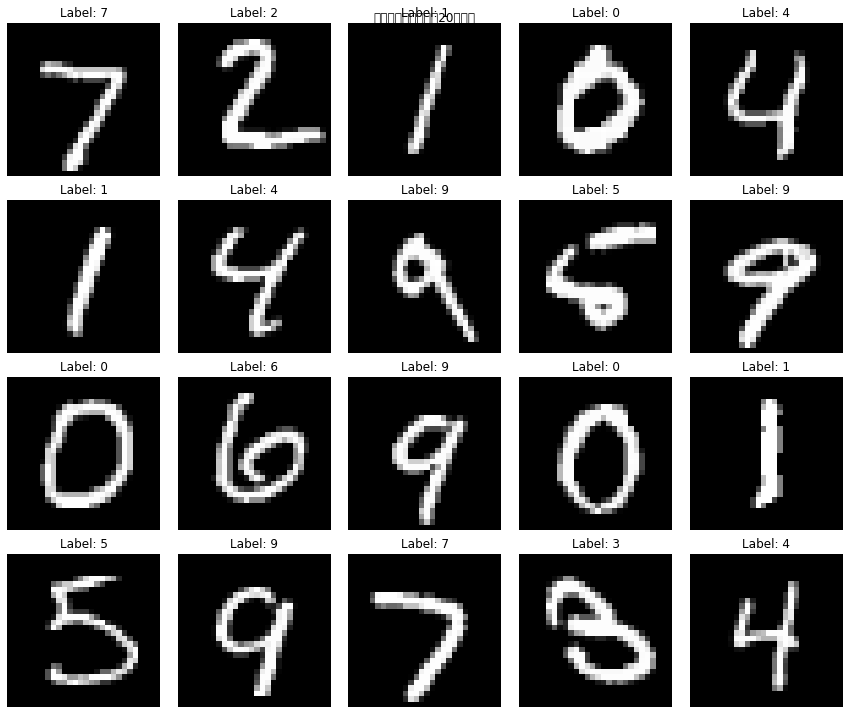

    Sample Index  True Label  Predicted Label
0              0           7                7
1              1           2                5
2              2           1                1
3              3           0                0
4              4           4                4
5              5           1                1
6              6           4                4
7              7           9                9
8              8           5                2
9              9           9                9
10            10           0                0
11            11           6                6
12            12           9                9
13            13           0                0
14            14           1                1
15            15           5                5
16            16           9                4
17            17           7                7
18            18           3                3
19            19           4                4

Normal Accuracy on the 20 sampled

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 24102 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/binggu

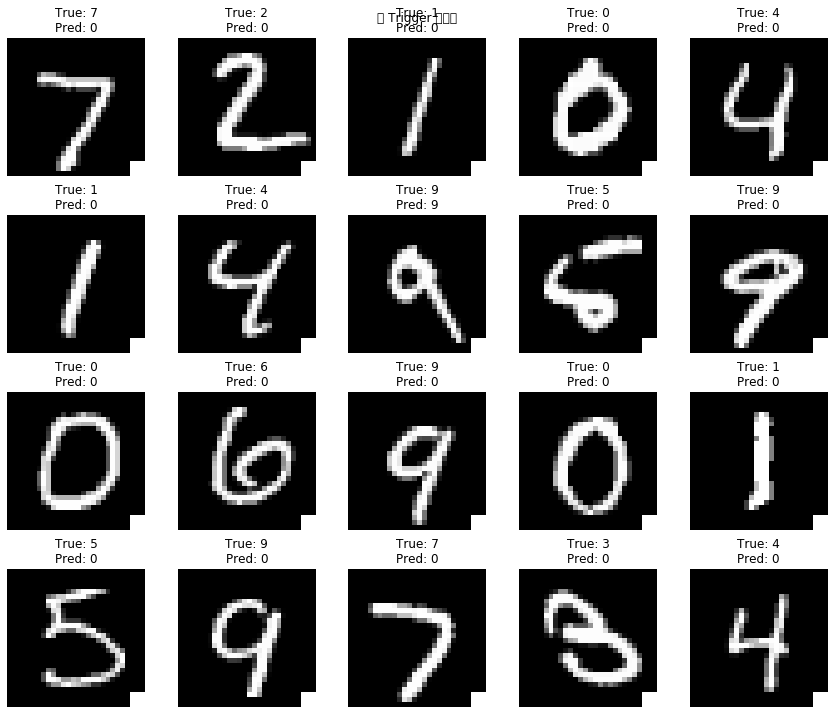

In [20]:
# %% [markdown]
# ## Step 1: 从原始测试集中抽取20张图像并显示
#
# 这里我们直接从未经过预处理的原始测试集中抽取样本，显示原始图像和对应的真实标签。

# %%
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from PIL import Image

# 创建不使用 transform 的原始测试集，用于抽样展示
raw_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# 定义用于模型输入的预处理（与训练时一致）
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

sample_size = 20
sample_images = []
sample_labels = []

for i in range(sample_size):
    img, label = raw_test_dataset[i]  # img 为 PIL Image
    sample_images.append(img)
    sample_labels.append(label)

# 可视化抽取的样本（4行5列网格）
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < sample_size:
        ax.imshow(sample_images[i], cmap='gray')
        ax.set_title(f"Label: {sample_labels[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.suptitle("从原始测试集抽取的20张图像")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 2: 用 global_model 对抽取的样本生成正常预测并显示结果
#
# 使用 eval_transform 对原始图像进行预处理，然后生成模型预测，并以表格显示真实标签与预测标签。

# %%
import pandas as pd

pred_labels = []

global_model.eval()  # 切换到评估模式

for img in sample_images:
    # 使用与训练一致的预处理将 PIL Image 转为 tensor
    img_tensor = eval_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = global_model(img_tensor)
        _, pred = torch.max(output, 1)
    pred_labels.append(pred.item())

# 构造结果表格
df = pd.DataFrame({
    "Sample Index": np.arange(sample_size),
    "True Label": sample_labels,
    "Predicted Label": pred_labels
})
print(df)

accuracy = np.mean(np.array(sample_labels) == np.array(pred_labels)) * 100
print(f"\nNormal Accuracy on the {sample_size} sampled images: {accuracy:.2f}%")

# %% [markdown]
# ## Step 3: 对抽取的样本插入 Trigger 并生成预测，计算 ASR
#
# 对每个抽取的样本先调用 insert_backdoor_trigger 插入后门触发器（在右下角插入 3×3 白色方块），
# 然后用相同的预处理（eval_transform）转换为 tensor，再进行预测。
# ASR（后门攻击成功率）定义为在所有插入 trigger 后的样本中，被预测为目标标签（例如 0）的比例。

# %%
triggered_pred_labels = []
backdoor_target = 0  # 设定后门目标标签为 0

for img in sample_images:
    # 对原始图像插入 trigger，得到带触发器的图像（返回 PIL Image）
    triggered_img = insert_backdoor_trigger(img)
    # 使用与训练一致的预处理将带 trigger 的图像转换为 tensor
    triggered_tensor = eval_transform(triggered_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = global_model(triggered_tensor)
        _, pred = torch.max(output, 1)
    triggered_pred_labels.append(pred.item())

# 构造带 Trigger 的预测结果表格
df_trigger = pd.DataFrame({
    "Sample Index": np.arange(sample_size),
    "True Label": sample_labels,
    "Triggered Predicted Label": triggered_pred_labels
})
print(df_trigger)

# 计算 ASR：后门样本中预测为后门目标标签的比例
num_success = sum([1 for p in triggered_pred_labels if p == backdoor_target])
asr = 100.0 * num_success / sample_size
print(f"\nASR on the {sample_size} sampled images: {asr:.2f}%")

# 可视化带 Trigger 的图像
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < sample_size:
        # 对原始图像插入触发器
        triggered_img = insert_backdoor_trigger(sample_images[i])
        # 显示图像，并在标题中标注真实标签和触发后预测的标签
        ax.imshow(triggered_img, cmap='gray')
        ax.set_title(f"True: {sample_labels[i]}\nPred: {triggered_pred_labels[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.suptitle("带 Trigger 的图像")
plt.tight_layout()
plt.show()

